## Loading dataset

In [40]:
import os, shutil
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import skimage as ski

In [41]:
def gaussian_blur_train(img):
    
    kst = [15,5,7,3,9,11,13]
    dgt = [3]
    
    kernel_size = kst[np.random.choice(len(kst))]
    sigma =  3
    
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        print(channels)
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

def blur_train(tnsr):
    kq = []
    for i in range(len(tnsr)):
        kq.append(gaussian_blur_train( np.expand_dims(tnsr[i],0)    )[0])
    return np.array(kq)

In [42]:
def gaussian_blur_test(img):
    
    kst = [5,7,9]
    dgt = [3]
    
    kernel_size = kst[np.random.choice(len(kst))]
    sigma =  3
    
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

def blur_test(tnsr):
    kq = []
    for i in range(len(tnsr)):
        kq.append(gaussian_blur_test( np.expand_dims(tnsr[i],0)    )[0])
    return np.array(kq)

In [43]:
img = plt.imread('/kaggle/input/camvid/CamVid/train/0001TP_009210.png')
resized_img = ski.transform.resize(img, (256,256), anti_aliasing=False)

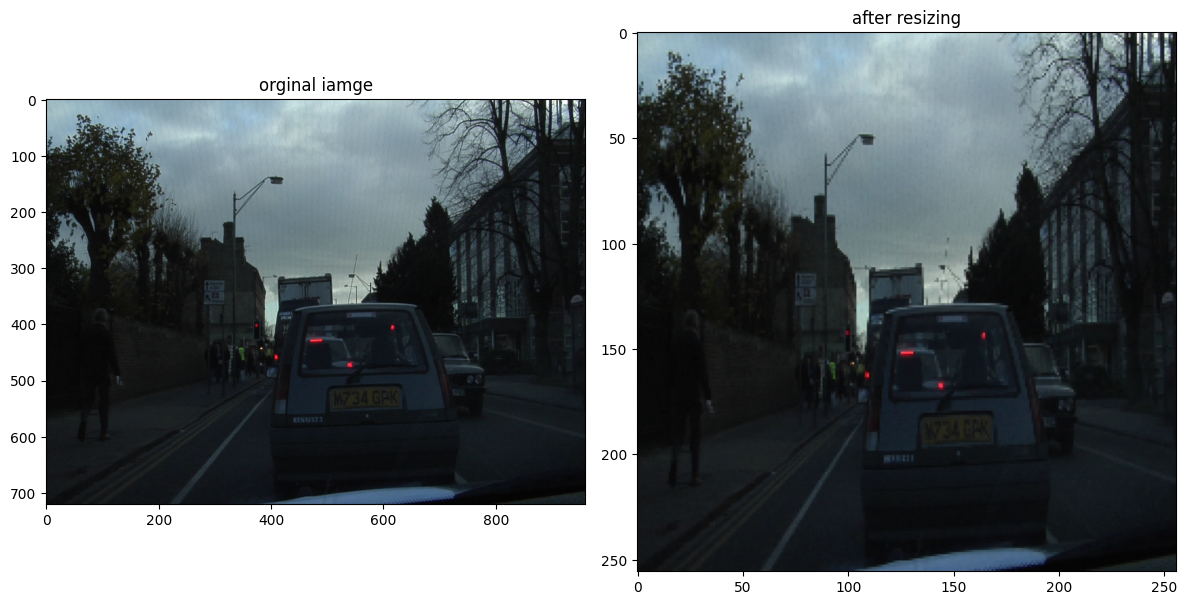

In [44]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.title('orginal iamge')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('after resizing')
plt.imshow(resized_img)
plt.tight_layout()

In [45]:
blured_img = blur_train([resized_img])

tf.Tensor(3, shape=(), dtype=int32)


In [46]:
blured_img = blured_img[0]
type(blured_img), blured_img.dtype, blured_img.shape

(numpy.ndarray, dtype('float32'), (256, 256, 3))

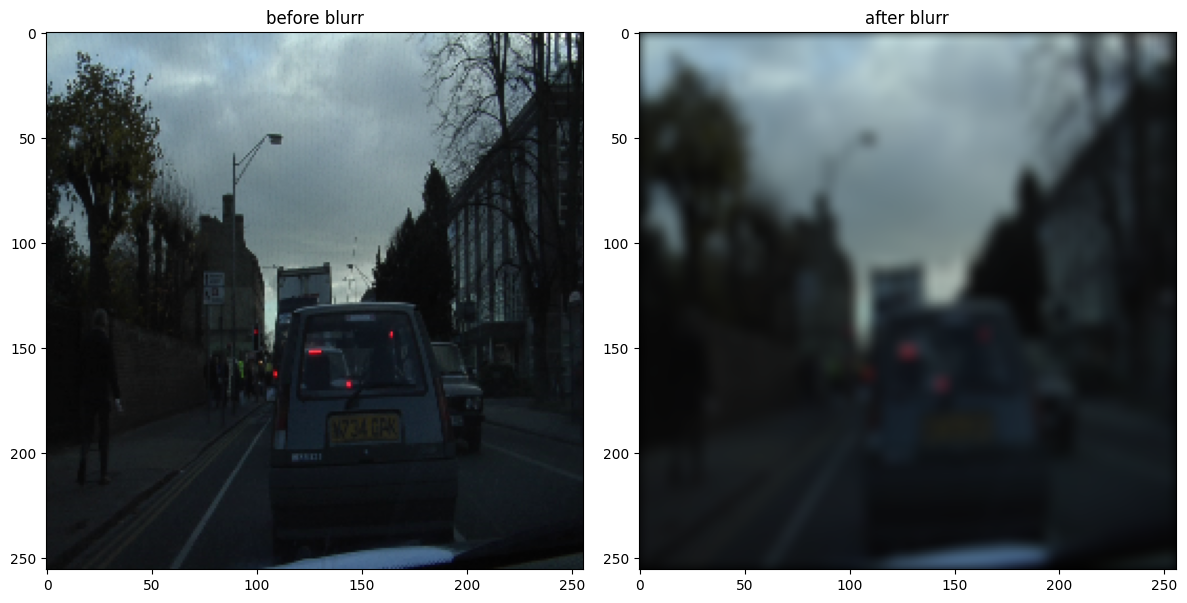

In [47]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.title('before blurr')
plt.imshow(resized_img)
plt.subplot(1,2,2)
plt.title('after blurr')
plt.imshow(blured_img)
plt.tight_layout()

## making dataset

In [49]:
def make_img_dataset(paths_list, resize=True, shape=(256,256)):
    img_list = []
    img_path_list = []
    for path in paths_list:
        f_name_list = os.listdir(path)
        path_list = [ path+f_name for f_name in f_name_list ]
        img_path_list += path_list
    img_path_list.sort()
#     print(len(img_path_list))
    
#     for im_name in img_name_list:
#         img = plt.imread(path+im_name)
#         img_list.append(img)
        
#         img_lsit = [plt.imread(path+im_name) for im_name in img_name_list]
    img_list = [plt.imread(im_path) for im_path in img_path_list]
    
    if resize:
        resized_im_list = [ski.transform.resize(img, shape, anti_aliasing=False) for img in img_list]
        return np.array(resized_im_list)
    
    np.random.shuffle(img_list)
    
    return np.array(img_list)

In [50]:
train_img_list = make_img_dataset(['/kaggle/input/camvid/CamVid/train/', '/kaggle/input/camvid/CamVid/val/'])
len(train_img_list)

469

In [51]:
test_img_list = make_img_dataset(['/kaggle/input/camvid/CamVid/test/'])
len(test_img_list)

232

In [ ]:
b_train1 = blur_train(train_img_list)
b_train2 = blur_train(train_img_list)
# b_train3 = blur_train(train_img_list)

In [53]:
b_test = blur_test(test_img_list)

In [54]:
# all_gt = train_img_list + train_img_list + train_img_list
# all_blr = b_train1 + b_train2 + b_train3

# all_gt = np.concatenate([train_img_list, train_img_list, train_img_list])
# all_blr = np.concatenate([b_train1, b_train2, b_train3])

all_gt = np.concatenate([train_img_list, train_img_list])
all_blr = np.concatenate([b_train1, b_train2])

In [55]:
type(all_gt), all_gt.shape, all_gt.dtype

(numpy.ndarray, (938, 256, 256, 3), dtype('float32'))

In [56]:
len(all_gt)

938

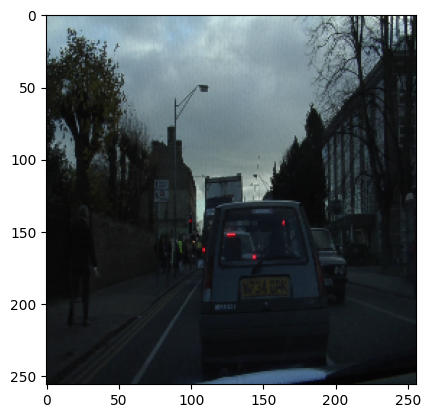

In [57]:
plt.imshow(all_gt[0])

In [58]:
# im = 27
# plt.figure(figsize=(10,16))
# plt.subplot(1,3,1)
# plt.imshow(train_img_list[im])
# plt.title('original image')
# plt.subplot(1,3,2)
# plt.imshow(b_train[im])
# plt.title('blurred image')
# plt.subplot(1,3,3)
# plt.imshow(bb_train[im])
# plt.title('double blurred image')
# plt.tight_layout()

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['figure.figsize'] = 8,8

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
#import keras
import random
import numpy as np
import os, math
from matplotlib.pyplot import figure
#from keras.backend import tensorflow_backend
from tensorflow.keras import backend as K
# from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import glob
import re
import tensorflow as tf
from skimage.io import imread
from matplotlib import pyplot as plt
# from skimage import segmentation, color
# from skimage import graph

import warnings
warnings.filterwarnings("ignore")

In [60]:
def plot_sample(lr, sr):
    plt.figure(figsize=(8, 6))

    images = [lr, sr]
    titles = ['denoised', 'noisy']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
def imgps(x):
    p = x[0] * 255
    p = p.astype(np.uint8)
    p = Image.fromarray(p)
    return p




def lsn(im,fc):
    d1=im.shape[1]
    d2=im.shape[2]
    d3=round(d1/fc)
    d4=round(d2/fc)
    w1=  (tf.image.resize(im, [d3, d4]))
    return np.asarray(tf.image.resize(w1, [d1, d2]))    

def hsn(im,fc):
    d1=im.shape[1]
    d2=im.shape[2]
    d3=round(d1*fc)
    d4=round(d2*fc)
    w1=  (tf.image.resize(im, [d3, d4]))
    return np.asarray(tf.image.resize(w1, [d1, d2])) 


def lsz(im,fc):
    d1=im.shape[1]
    d2=im.shape[2]
    d3=round(d1//fc)
    d4=round(d2//fc)
    w1=  (tf.image.resize(im, [d3, d4]))
    return np.asarray( w1)

def sub3(f1,f2,f3):
 
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131)
    plt.imshow(f1)
    plt.title("Truth image")
    plt.subplot(132)
    plt.imshow(f2)
    plt.title("Restored image")
    plt.subplot(133)
    plt.imshow(f3)
    plt.title("Corrupted image")
    plt.show()
    
def adik(im):
    a= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
    a= cv2.resize(a, (256,256), interpolation=cv2.INTER_CUBIC)
    return a    


def tjpg(tn):
    t1=list()
    for i in range(len(tn)):
        c1=tn[i]
        #j1=np.asarray(tf.image.adjust_contrast(tf.image.random_jpeg_quality(c1, 30, 55),1.09))
        j1=np.asarray( (tf.image.random_jpeg_quality(c1, 30, 32) ))
        t1.append(np.clip(j1,0,1))
    return np.asarray(t1)




def dtls(x):
    x1=x
    x2= np.uint8(255*x1)
    sd= (x2- cv2.medianBlur(x2,3))/255
    fo= np.clip((x+sd),0,1)
    return fo

def swap(img, patch, s1, s2, s3):
    img[s1:s3, s2:s3] = patch
    return img

def cutblur(im1, im2):
    
    h, w = im1.shape[1], im1.shape[0]
    
    hr = im1.copy()
    lr = im2.copy()
    
    f = h//2 - 2
    
    r1 = np.random.randint(0, f)//2 
    r2 = np.random.randint(0, f)//2 
    
    #r1=r1+40
    #r2=r1+30
    
    hp = im1[r1:f, r2:f].copy()
    lp = im2[r1:f, r2:f].copy()
 
    
    #print(r1,r2,f)
    
    
    
    temp1 = swap(hr, lp, r1, r2, f)
    temp2 = swap(lr, hp, r1, r2, f)
    
    return temp1, temp2



def cuten(d1,d2):
    x1=list()
    y1=list()
    for i in range(len(d1)):
        xx=d1[i]
        yy=d2[i]
        ax,by=cutblur(xx,yy)
        x1.append(ax)
        y1.append(by)
    return np.asarray(x1), np.asarray(y1)
    
    
    
    
def rota(xy,dg):
    if dg==1:
        ro= np.rot90((np.asarray(xy)) ,k=1, axes=(1, 2))    
    elif dg==2:
        ro= np.rot90((np.asarray(xy)) ,k=2, axes=(1, 2))    
    elif dg==3:
        ro= np.rot90((np.asarray(xy)) ,k=3, axes=(1, 2))    
    return ro

def ox(a):
    return np.expand_dims(a,axis=0)

def nod(x,fc):
    nx= np.random.normal(scale=fc/255, size=x.shape)
    ad= np.clip(x+nx,0,1)
    return ad



def nodr(x ):
    nx= np.random.normal(scale=random.randint(5, 25)/255, size=x.shape)
    ad= np.clip(x+nx,0,1)
    return ad


 

In [61]:
def ca1(y_true, y_pred):
    
    y_pred=y_pred
            
    er = .85*mce( y_true,y_pred)+ .85*SSIMLoss(y_true, y_pred )  
    return  er
 
def cae(y_true, y_pred):
    no= abs(K.random_normal(tf.shape(y_pred),mean=0.0, stddev=.30,dtype=None,seed=5))      
        
        
    er = K.binary_crossentropy(y_true, y_pred+no)
    return er 

def cbc(y_true, y_pred):
    
        
        
    er = K.binary_crossentropy(y_true, y_pred)
    return er
    
def hu(x,fa):
    return tf.image.adjust_hue(x,fa )

def con(x,fa):
    return tf.image.adjust_contrast(x,fa )


def gm(x,fa):
    return tf.image.adjust_gamma(x,fa )

def brt(x,fa):
    return tf.image.adjust_brightness(x,fa )

def aug(x):
    a1=tf.image.flip_left_right(x )
    a2=tf.image.flip_up_down(x )
    a3=tf.image.transpose(x )
    return a1,a2,a3


def lsr(im,fc):
    d1=im.shape[1]
    d2=im.shape[2]
    d3=round(d1/fc)
    d4=round(d2/fc)
    w1=  (tf.image.resize(im, [d3, d4]))
    return  np.float32(tf.image.resize(w1, [d1, d2])) 


def mce(y_true, y_pred):
            
    evas = K.abs(y_pred - y_true)
    evas = K.mean(evas, axis=-1)
        
    return evas

def msse(y_true, y_pred):
        
    return (tf.keras.losses.mse(y_true, y_pred))

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def ca3(y_true, y_pred):
    
#     na=K.random_normal(tf.shape(y_true),mean=0.0, stddev=.80,dtype=None,seed=5)
    
#     #y_pred=y_pred+na
#     y_true=y_true+na
    
    g1,g2,g3=aug(y_true)   
    pr1,pr2,pr3=aug(y_pred)  
 
    
    l1=(ca1(g1,pr1)+ca1(g2,pr2)+ca1(g3,pr3))/3
    l2=(ca1(1-g1,1-pr1)+ca1(1-g2,1-pr2)+ca1(1-g3,1-pr3))/3
    l3=ca1(y_true, y_pred)
    
    
 
    return    (l1+ l2+ l3)/3
    

def ca4(y_true, y_pred):
    a=y_true[:,:,:,0:3]
    b=y_true[:,:,:,3:6]
    
    # y_pred=y_pred+na
#     y_true=y_true+na  
    return (ca1(a, y_pred)/2+ca1(b, y_pred))/2

 

def caa(y_true, y_pred):
    
    #a1=tf.image.flip_up_down(y_true)
    #a2=tf.image.flip_left_right(y_true)  
    #n= np.random.normal(scale=10/255, size=y_true.shape)
    
    a=tf.image.sobel_edges(y_true)
    b=tf.image.sobel_edges(y_pred)
    
    er =  mce(a , b) + tf.reduce_mean( mce(y_true, y_pred)) 
    return  er/2  

# Model

In [62]:
def mdsr1(ix,f):
    x=Conv2D(f, kernel_size=3, strides=1, padding='same')(ix)
    
    x1=r1(x,f)
    x1=r1(x1,f)
    x2=r1(x,f)
    x2=r1(x2,f)
    x3=r1(x,f)
    x3=r1(x3,f)
    x=add([x1,x2,x3])
    x=concatenate([x,x1,x2,x3 ], axis = 3)
    x=Conv2D(f, kernel_size=3, strides=1, padding='same')(x)
    return x 


def r1(input_tensor, features ):
    x = Conv2D(features, 3, activation='relu', padding='same')(input_tensor)
    x = Conv2D(features, 3, padding='same')(x)
    return add([input_tensor, x])

def global_repsonse_norm(tnsr_op):

    axis = -1
    num_dims = len(tnsr_op.shape)
    norm_scale = tf.cast(tf.shape(tnsr_op)[1] * tf.shape(tnsr_op)[2], tnsr_op.dtype) ** 0.5
    nn_op = tf.reduce_mean(tf.math.square(tnsr_op),
                              axis=[ii for ii in range(1, num_dims) if ii != axis], keepdims=True)
    nn_op = tf.math.sqrt(nn_op) * norm_scale
    nn_op = nn_op / (tf.reduce_mean(nn_op, axis=axis, keepdims=True) + 1e-6)
    return tnsr_op + nn_op


In [63]:
def DnCNN():
    input_img = Input(shape=(None,None,3))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input_img)
    x = Activation('relu')(x)
        # 15 layers, Conv+BN+relu
    for i in range(15):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        #x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)   
        # last layer, Conv
    x = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([input_img, x])   # input - noise

    model = Model(input_img, x)
    return model


def Dnsr():
    input_img = Input(shape=(None,None,3))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input_img)
    x0 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same')(input_img)
    y0 = mdsr1(x0,64)
    for i in range(5):
        x =  r1(x,64)
        x = global_repsonse_norm(add([x , x0]))
    x = concatenate([y0,x])    
    x = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    
    x = add([x , input_img])
    
    
    model = Model(input_img, x)
    return model


model = Dnsr()

 


opt = keras.optimizers.Adam( )

model.compile(loss='mae', optimizer=opt,    metrics=[  "accuracy"])

In [64]:
 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.4,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

filepath="A_cvpru.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
def psnr_m(y_true, y_pred,):
    return  tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))
    
def ssim_m(y_true, y_pred,):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    

In [65]:
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)) 

def msse(y_true, y_pred):
    return K.mean(tf.keras.losses.mse(y_true, y_pred))


def closs(y_true, y_pred):
    return ( 0.2* SSIMLoss(y_true, y_pred)  + msse(y_true, y_pred))

In [66]:
def sub3(f1,f2,f3):
 
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131)
    plt.imshow(f1)
    plt.title("Truth image")
    plt.subplot(132)
    plt.imshow(f2)
    plt.title("Restored image")
    plt.subplot(133)
    plt.imshow(f3)
    plt.title("Corrupted image")
    plt.show()

## Self-supervised denoising

In [67]:
X_train, X_val, y_train, y_val = train_test_split( all_blr, all_gt,  test_size=0.1, random_state=42)

In [68]:
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [69]:
# type(X_train), X_train.dtype, len(X_train)

In [70]:
# augmentation function

def aug_aftr(ary, optn):
    if optn ==1:
        aryaug = tf.image.flip_up_down(ary)
    if optn ==2:
        aryaug=tf.image.transpose(ary )
    else:
        aryaug = tf.image.flip_left_right(ary)
    return aryaug
        




X_traina = np.concatenate([X_train,  aug_aftr(X_train,3), aug_aftr(X_train,1), aug_aftr(X_train,2)])
y_traina = np.concatenate([y_train,  aug_aftr(y_train,3), aug_aftr(y_train,1), aug_aftr(y_train,2)]) 

In [ ]:
# bzs = 16

# b_train = X_train
 

# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# val_dataset = val_dataset.batch(bzs)

# # In self supervised setup, we dont have clean target for the trianing image;
# # hence, the dataset is unpaired
# # We have create our own apporoach to make it paired or at least self paired.

# b_train_plus = blur_train(X_train)


bzs = 16

b_train = X_traina
 

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(bzs)

# In self supervised setup, we dont have clean target for the trianing image;
# hence, the dataset is unpaired
# We have create our own apporoach to make it paired or at least self paired.

b_train_plus = blur_train(X_traina)

## using Dnsr

In [72]:
dnsr_model = Dnsr()
dnsr_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, None, None, 64)       1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_43 (Conv2D)          (None, None, None, 64)       36928     ['conv2d_27[0][0]']           
                                                                                                  
 conv2d_44 (Conv2D)          (None, None, None, 64)       36928     ['conv2d_43[0][0]']           
                                                                                            

In [73]:
dnsr_model.compile(loss='mse', optimizer='adam', metrics=[psnr_m,ssim_m, "accuracy"]) 
history = dnsr_model.fit(b_train_plus, b_train, validation_data=val_dataset,
                    epochs=45, batch_size=8, callbacks = [checkpoint,reduce_lr])

Epoch 1/45
422/422 [==============================] - ETA: 0s - loss: 1.3249 - psnr_m: 22.5863 - ssim_m: inf - accuracy: 0.5206
Epoch 1: val_loss improved from inf to 0.00898, saving model to A_cvpru.h5
422/422 [==============================] - 381s 859ms/step - loss: 1.3249 - psnr_m: 22.5863 - ssim_m: inf - accuracy: 0.5206 - val_loss: 0.0090 - val_psnr_m: 20.7234 - val_ssim_m: 0.6067 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 2/45
422/422 [==============================] - ETA: 0s - loss: 0.0032 - psnr_m: 28.0805 - ssim_m: 0.9100 - accuracy: 0.5978
Epoch 2: val_loss improved from 0.00898 to 0.00847, saving model to A_cvpru.h5
422/422 [==============================] - 353s 836ms/step - loss: 0.0032 - psnr_m: 28.0805 - ssim_m: 0.9100 - accuracy: 0.5978 - val_loss: 0.0085 - val_psnr_m: 21.0108 - val_ssim_m: 0.6183 - val_accuracy: 0.6348 - lr: 0.0010
Epoch 3/45
422/422 [==============================] - ETA: 0s - loss: 9.6219e-04 - psnr_m: 31.5074 - ssim_m: 0.9374 - accuracy: 0.6727
Epo

8/8 [==============================] - 8s 958ms/step
psnr 23.618603
ssim 0.70600915


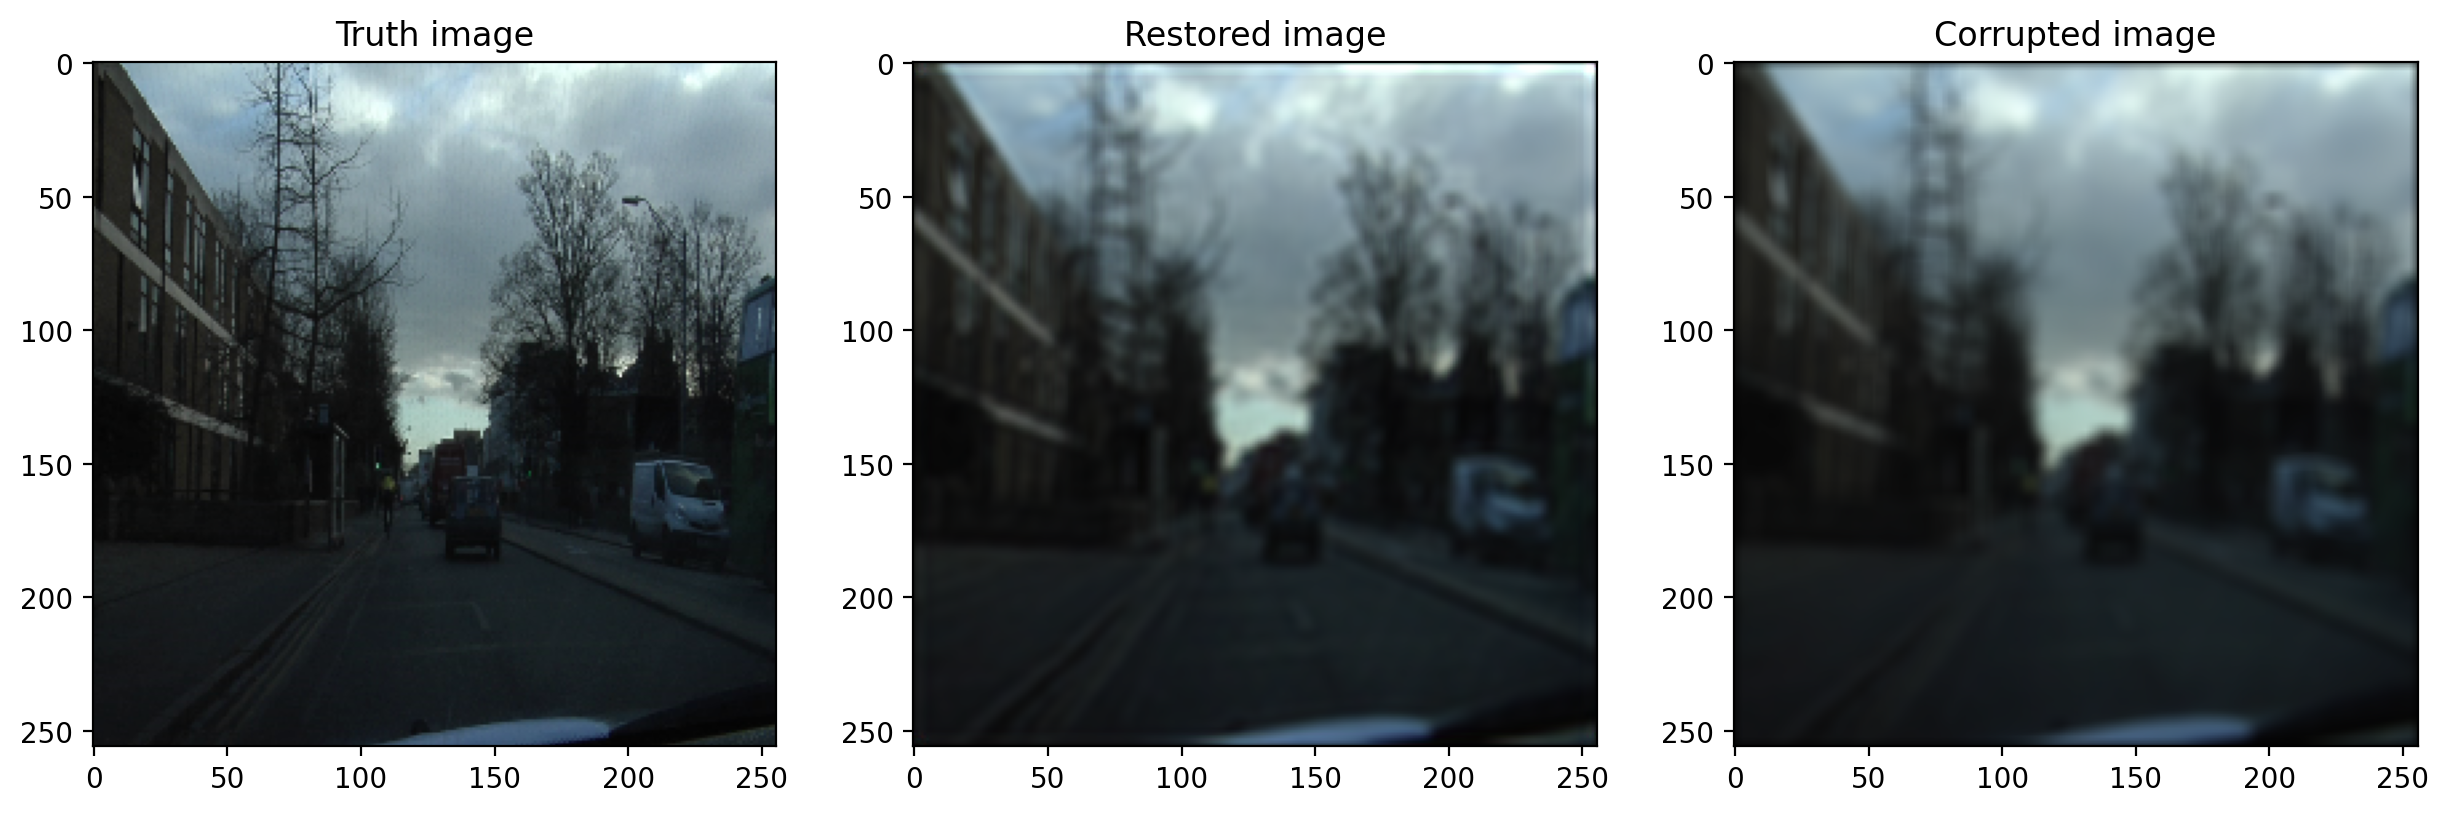

In [76]:
X_val_p_self = dnsr_model.predict(b_test)

print('psnr',psnr_m(test_img_list,X_val_p_self  ).numpy())

print('ssim',ssim_m(test_img_list,X_val_p_self  ).numpy())

rid = 17
sub3(test_img_list[rid],X_val_p_self[rid],b_test[rid] )

## Loading segmentation model

In [77]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import skimage as ski

import os
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
# from tensorflow.keras.utils import *
from tensorflow.keras.regularizers import * 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [78]:
# loading test image
def make_img_dataset(paths_list, resize=True, shape=(256,256)):
    img_list = []
    img_path_list = []
    for path in paths_list:
        f_name_list = os.listdir(path)
        path_list = [ path+f_name for f_name in f_name_list ]
        img_path_list += path_list
    img_path_list.sort()
#     print(len(img_path_list))
    
#     for im_name in img_name_list:
#         img = plt.imread(path+im_name)
#         img_list.append(img)
        
#         img_lsit = [plt.imread(path+im_name) for im_name in img_name_list]
    img_list = [plt.imread(im_path) for im_path in img_path_list]
    
    if resize:
        resized_im_list = [ski.transform.resize(img, shape, anti_aliasing=False) for img in img_list]
        return np.array(resized_im_list)
    
    return np.array(img_list)

In [79]:
 # Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()


@keras.saving.register_keras_serializable(package="my_package", name="dice")
def dice(y_true, y_pred, smooth=1):
    
    intersection = K.sum(y_true * y_pred, axis=[-1])
    union = K.sum(y_true, axis=[-1]) + K.sum(y_pred, axis=[-1])
    dicef = K.mean((2. * intersection + smooth)/(union + smooth), axis=-1)
    return dicef


@keras.saving.register_keras_serializable(package="my_package", name="IOU")
def IOU(y_true, y_pred, smooth=1):

    intersection = K.sum(y_true * y_pred, axis=[-1])
    union = K.sum(y_true, axis=[-1]) + K.sum(y_pred, axis=[-1])-intersection
    iou_scr = K.mean(( intersection + smooth)/(union + smooth), axis=-1)
    return iou_scr

In [80]:
# reconstructed_seg_model = keras.models.load_model(
#     "/kaggle/input/custom-segmentation-mode/custom_seg_model.hdf5",
#     custom_objects={"dice": dice, "IOU": IOU},
# )


reconstructed_seg_model = keras.models.load_model(
    "/kaggle/input/latest-segmentation-model/custom_seg_model_latest.hdf5",
    custom_objects={"dice": dice, "IOU": IOU},
    compile = False
)

In [81]:
reconstructed_deblur_model = keras.models.load_model(
    '/kaggle/working/A_cvpru.h5',
    compile = False
)

In [82]:
def sub3(f1,f2,f3):
 
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131)
    plt.imshow(f1)
    plt.title("Truth image")
    plt.subplot(132)
    plt.imshow(f2)
    plt.title("Restored image")
    plt.subplot(133)
    plt.imshow(f3)
    plt.title("Corrupted image")
    plt.show()

In [83]:
### mapping mask labels

classes = pd.read_csv('/kaggle/input/camvid/CamVid/class_dict.csv')

classes_dict = {classes.loc[cl][0]:list(classes.loc[cl][1:]) for cl in classes.index}

idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(classes_dict.items())}

def map_class_to_rgb(p):
    return idx2rgb[p[0]]

In [8]:
# reconstructed_deblur_model = keras.models.load_model(
#     "/kaggle/working/A_cvpru.h5",
#     custom_objects={"dice": dice, "IOU": IOU},
# )

In [9]:
# def visualize_seg(img, gt_mask, shape='normal', gt_mode='sparse'):
#   fig , ax = plt.subplots(1,3,figsize=(10,10))
  
#   # Img
#   ax[0].imshow(img)
#   ax[0].set_title("Orignal Image")
  
#   # Predict
# #   pred_mask = model.predict(np.expand_dims(img, 0))
#   pred_mask = reconstructed_seg_model.predict(np.expand_dims(img, 0))
#   pred_mask = np.argmax(pred_mask, axis=-1)
#   pred_mask = pred_mask[0]
#   if shape=='flat':
#     pred_mask = np.reshape(pred_mask, (256,256)) # Reshape only if you use the flat model. O.w. you dont need
  
#   rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
  
#   # Prediction
#   ax[1].imshow(rgb_mask)
#   ax[1].set_title("Predicted Mask")

              
#   # GT mask
#   if gt_mode == 'ohe':
#     gt_img_ohe = np.argmax(gt_mask, axis=-1)
#     gt_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))              
  
#     ax[2].imshow((gt_mask).astype(np.uint8))
#     ax[2].set_title("Ground truth")

In [84]:
def viz_seg(img, gt_mask, shape='normal', gt_mode='sparse'):
    fig , ax = plt.subplots(1,3,figsize=(12,10))

    # Img
    ax[0].imshow(img)
    ax[0].set_title("Orignal Image")

    # Predict
    #   pred_mask = model.predict(np.expand_dims(img, 0))
    pred_mask = reconstructed_seg_model.predict(np.expand_dims(img, 0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    if shape=='flat':
        pred_mask = np.reshape(pred_mask, (256,256)) # Reshape only if you use the flat model. O.w. you dont need

    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))

    # Prediction
    ax[1].imshow(rgb_mask)
    ax[1].set_title("Predicted Mask")


    # GT mask
    if gt_mode == 'ohe':
        gt_img_ohe = np.argmax(gt_mask, axis=-1)
        gt_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))         

    ax[2].imshow(gt_mask)
    ax[2].set_title("Ground truth")

In [85]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(32):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [86]:
def psnr_m(y_true, y_pred,):
    return  tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))
    
def ssim_m(y_true, y_pred,):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [87]:
def make_test_dataset(path, shape=(256,256)):
    f_name_list = os.listdir(path)
    f_name_list.sort()
    path_list = [ path+f_name for f_name in f_name_list ]
    img_path_list = path_list
    img_list = [plt.imread(im_path) for im_path in img_path_list]
    resized_im_list = [ski.transform.resize(img, shape, anti_aliasing=False) for img in img_list]
    return np.array(resized_im_list)

In [88]:
def gaussian_blur_test(img):
    
    kst = [5,7,9]
    dgt = [3]
    
    kernel_size = kst[np.random.choice(len(kst))]
    sigma =  3
    
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

def blur_test(tnsr):
    kq = []
    for i in range(len(tnsr)):
        kq.append(gaussian_blur_test( np.expand_dims(tnsr[i],0)    )[0])
    return np.array(kq)

### loading test images and labels

In [89]:
test_img = make_test_dataset('/kaggle/input/camvid/CamVid/test/')
test_img_mask = make_test_dataset('/kaggle/input/camvid/CamVid/test_labels/')
b_test_img = blur_test(test_img)

In [90]:
batch_sz = 8
data_gen_args = dict(rescale=1./255)

# So our usage here is as data loader instead of loading everything in RAM, not data augmentation
mask_gen_args = dict()

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

BASE_PATH = "/kaggle/input/camvid/CamVid/"

# test_image_generator = image_datagen.flow_from_directory(
#     BASE_PATH,
#     class_mode=None,
#     classes=['test'],
#     seed=seed,
#     batch_size=batch_sz,
#     target_size=(256,256))

# test_mask_generator = mask_datagen.flow_from_directory(
#     BASE_PATH,
#     classes=['test_labels'],
#     class_mode=None,
#     seed=seed,
#     batch_size=batch_sz,
#     color_mode='rgb',
#     target_size=(256,256



b_test_image_generator = image_datagen.flow(
    b_test_img,
    batch_size=batch_sz,
    seed=seed,
    ignore_class_split=False,
    
#     class_mode=None,
#     classes=['test'],
#     target_size=(256,256)
    )

test_image_generator = image_datagen.flow(
    test_img,
    batch_size=batch_sz,
    seed=seed,
    ignore_class_split=False,
    )

test_mask_generator = image_datagen.flow(
    test_img_mask,
    batch_size=batch_sz,
    seed=seed,
    ignore_class_split=False,
    )

test_generator = zip(test_image_generator, test_mask_generator)
b_test_generator = zip(b_test_image_generator, test_mask_generator)

8/8 [==============================] - 8s 960ms/step
psnr 23.622572
ssim 0.7065755


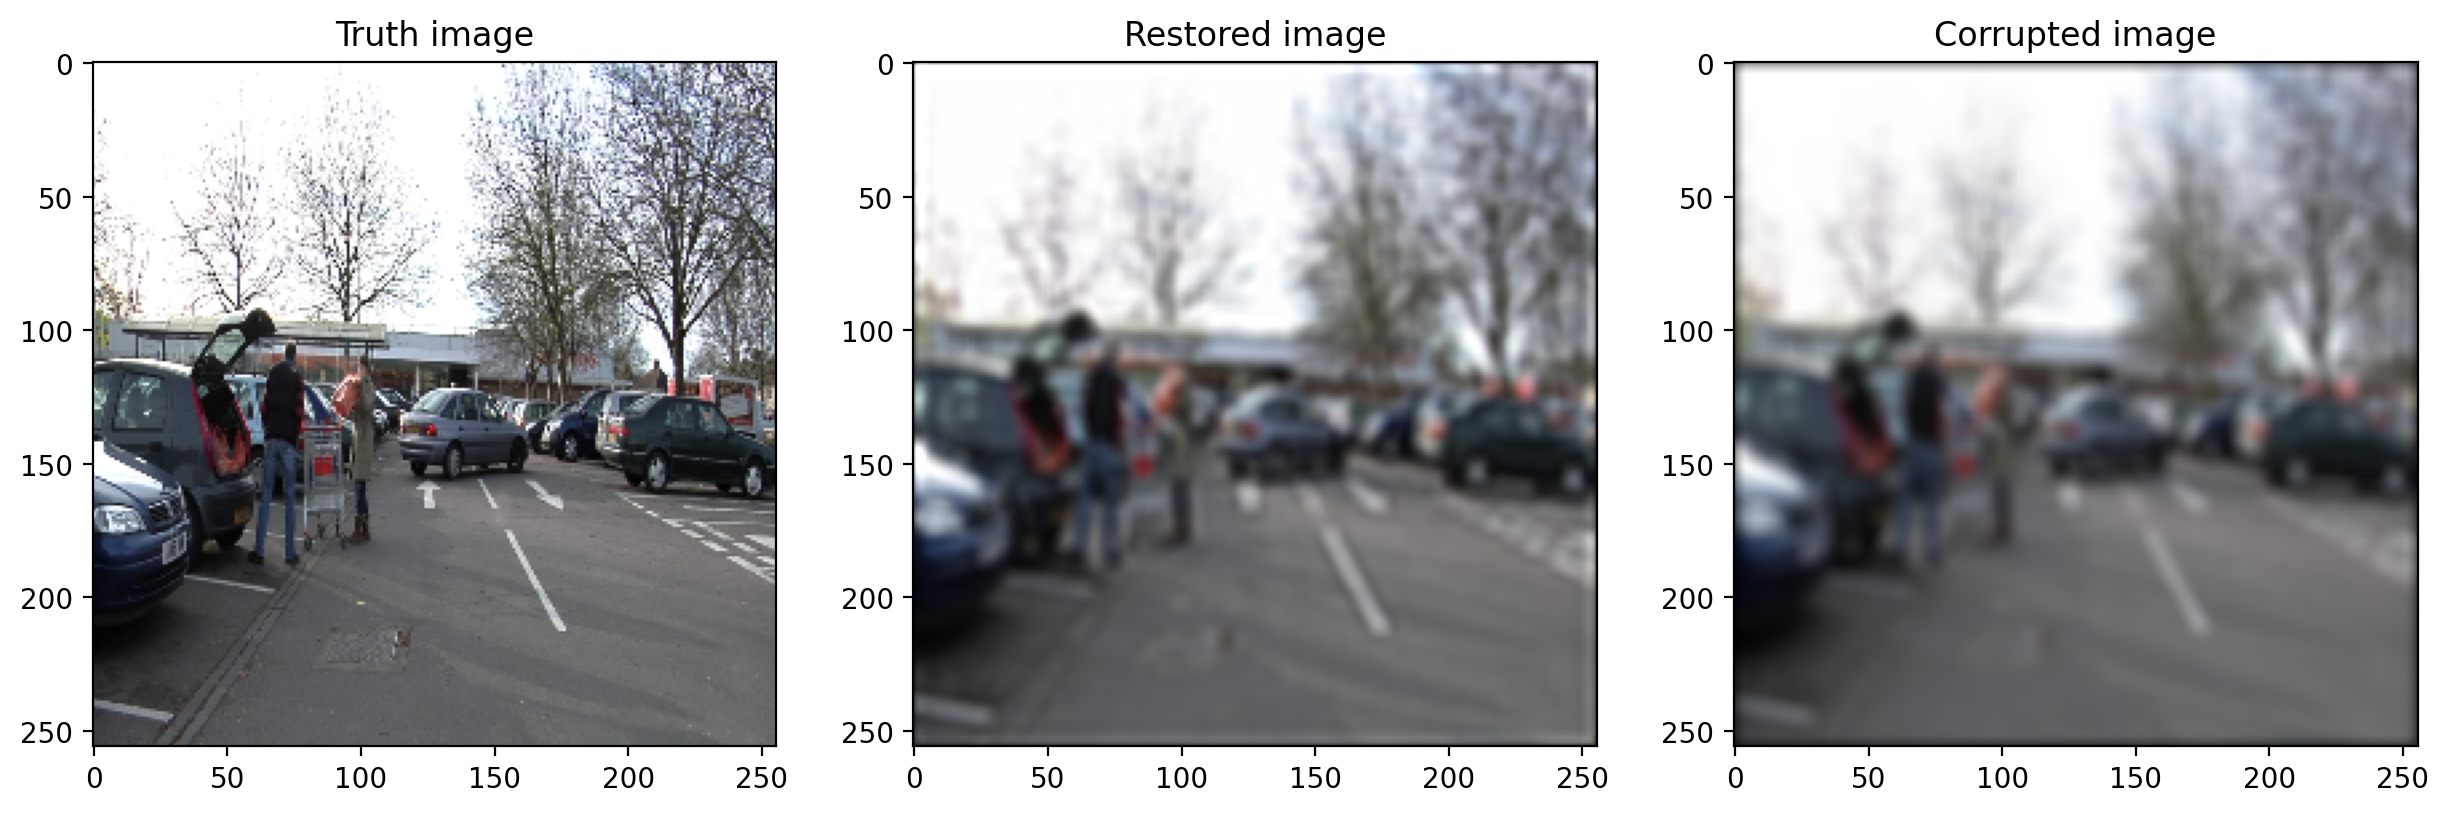

In [91]:
X_val_p_self = reconstructed_deblur_model.predict(b_test_img)

print('psnr',psnr_m(test_img,X_val_p_self  ).numpy())

print('ssim',ssim_m(test_img,X_val_p_self  ).numpy())

rid = 100
sub3(test_img[rid],X_val_p_self[rid],b_test_img[rid] )

1/1 [==============================] - 0s 25ms/step
iou score, dice score [0.252248128293241] [0.4028724381441714]


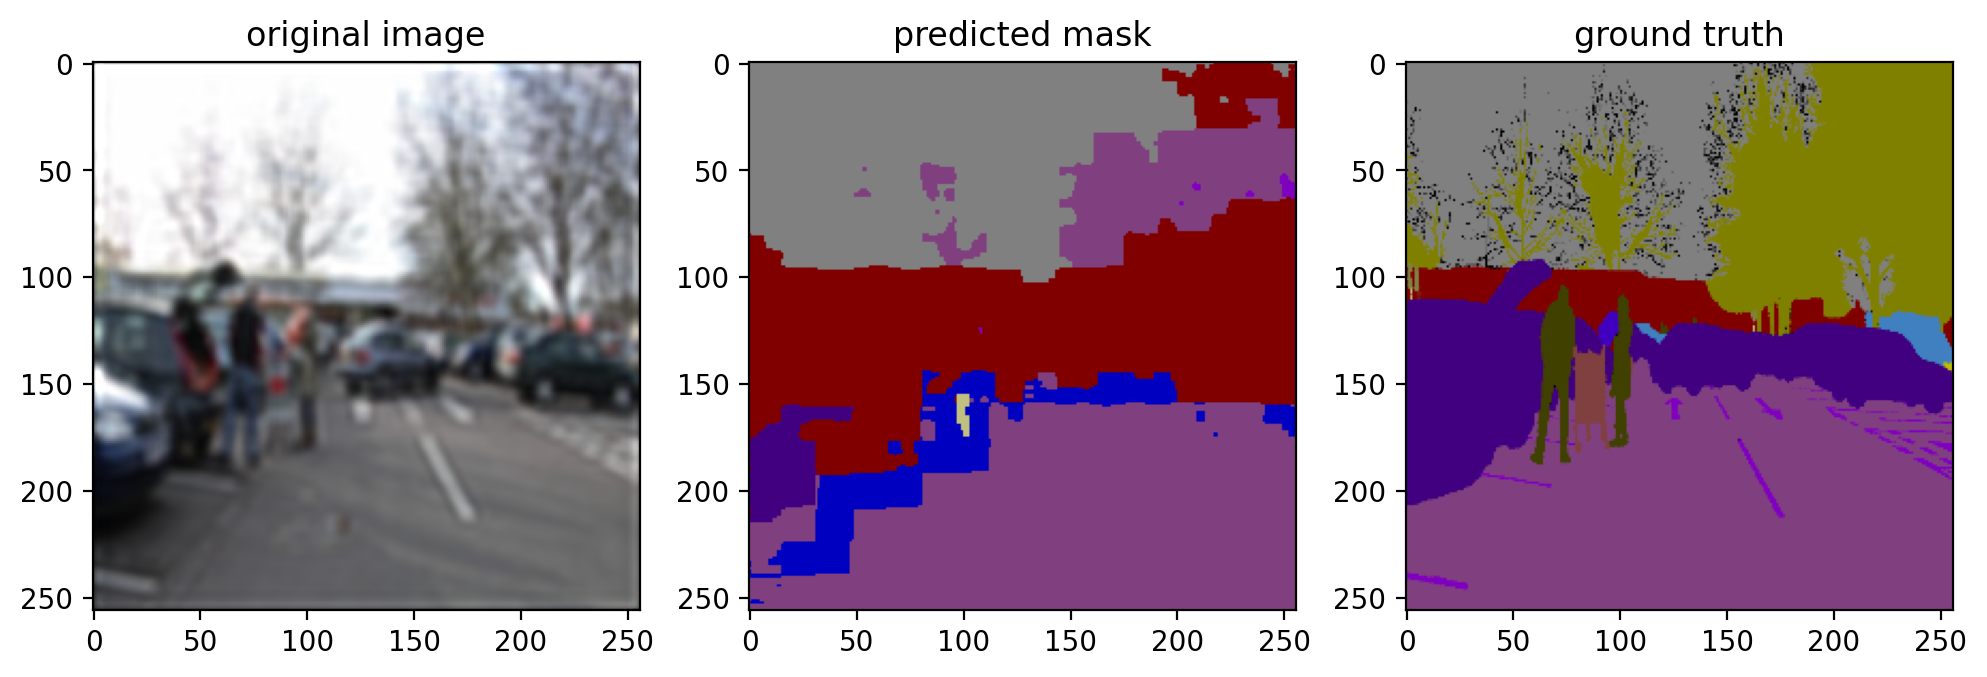

In [103]:
# imn = 10
img = X_val_p_self[rid]
gt_img = test_img_mask[rid]
p_img = reconstructed_seg_model.predict(np.expand_dims(img, 0))[0]
pred_mask = np.argmax(p_img, axis=-1)
rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))

im_iou, im_dice = compute_metrics(np.uint8(gt_img),np.uint8(rgb_mask))

print('iou score, dice score',im_iou, im_dice  )

# viz_seg(X_val_p_self[rid], test_img_mask[rid], shape='normal', gt_mode='sparse')

plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.title('deblurred image')
plt.imshow(img)
plt.subplot(1,3,2)
plt.title('predicted mask')
plt.imshow(rgb_mask)
plt.subplot(1,3,3)
plt.title('ground truth')
plt.imshow(gt_img)

1/1 [==============================] - 0s 23ms/step
iou score, dice score [0.2323354085676913] [0.3770652161124177]


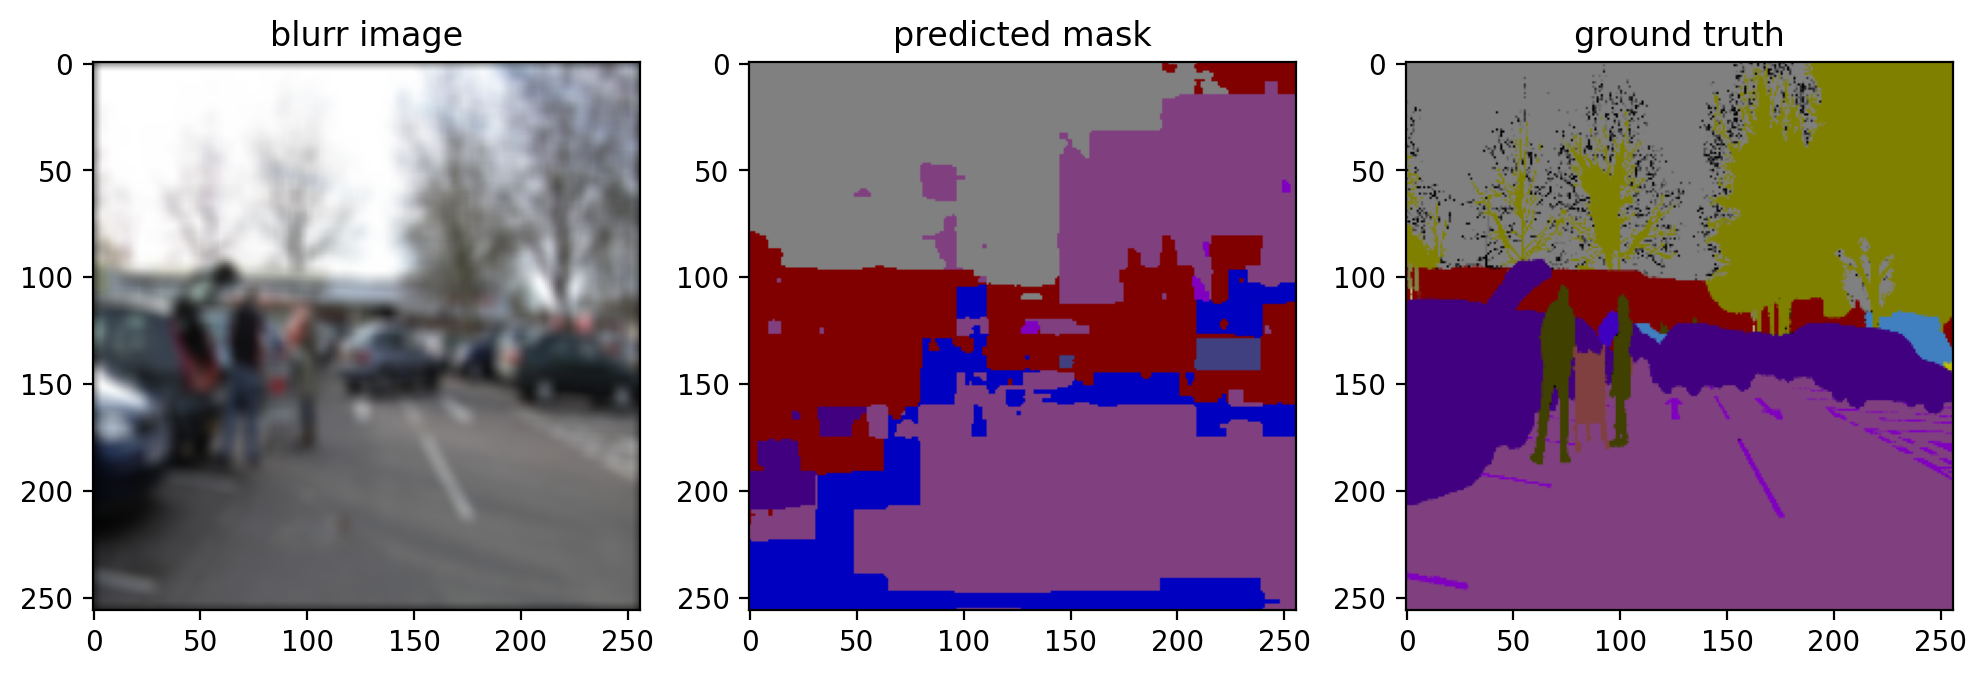

In [102]:
img = b_test_img[rid]
gt_img = test_img_mask[rid]
p_img = reconstructed_seg_model.predict(np.expand_dims(img, 0))[0]
pred_mask = np.argmax(p_img, axis=-1)
rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))

im_iou, im_dice = compute_metrics(np.uint8(gt_img),np.uint8(rgb_mask))

print('iou score, dice score',im_iou, im_dice  )

# viz_seg(b_test_img[rid], test_img_mask[rid], shape='normal', gt_mode='sparse')

plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.title('blurr image')
plt.imshow(img)
plt.subplot(1,3,2)
plt.title('predicted mask')
plt.imshow(rgb_mask)
plt.subplot(1,3,3)
plt.title('ground truth')
plt.imshow(gt_img)

1/1 [==============================] - 0s 22ms/step
iou score, dice score [0.18538411462476687] [0.31278319381123926]


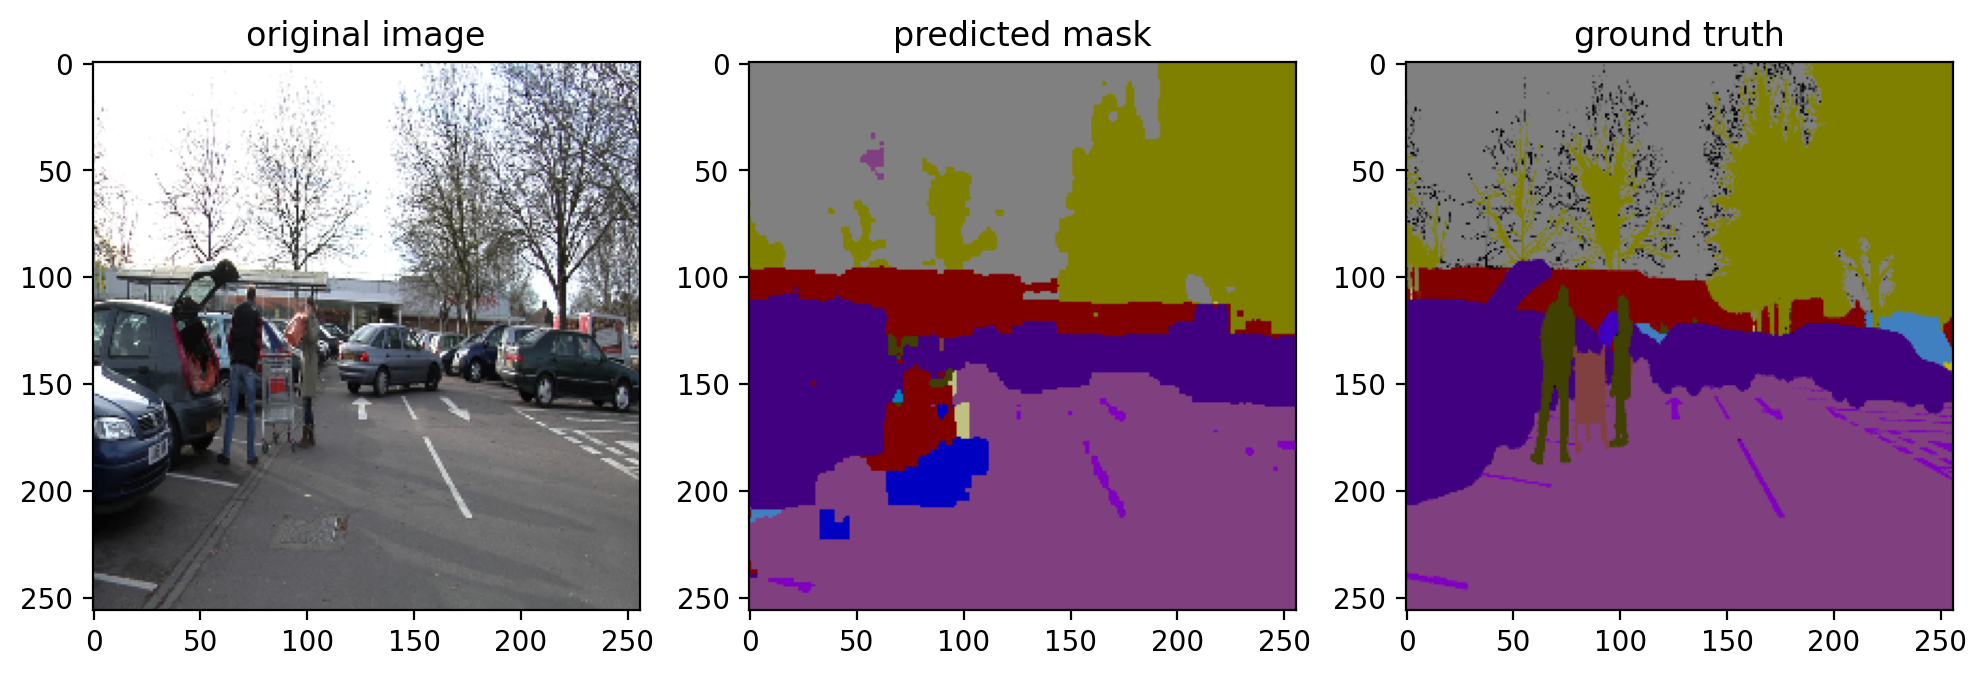

In [100]:
img = test_img[rid]
gt_img = test_img_mask[rid]
p_img = reconstructed_seg_model.predict(np.expand_dims(img, 0))[0]
pred_mask = np.argmax(p_img, axis=-1)
rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))

im_iou, im_dice = compute_metrics(np.uint8(gt_img),np.uint8(rgb_mask))

print('iou score, dice score',im_iou, im_dice  )

# viz_seg(test_img[rid], test_img_mask[rid], shape='normal', gt_mode='sparse')

plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(img)
plt.subplot(1,3,2)
plt.title('predicted mask')
plt.imshow(rgb_mask)
plt.subplot(1,3,3)
plt.title('ground truth')
plt.imshow(gt_img)